In [1]:
using LinearAlgebra
using Random
using Distributions
using KernelDensity
include("../Inversion/Plot.jl")
include("../Inversion/GaussianMixture.jl")
include("../Inversion/GMBBVI.jl")
include("../Inversion/AnnealingInitialize.jl")
include("./MultiModal.jl")
Random.seed!(123);


In [2]:
function visualization(ax, objs, func_Phi;
    N_ens_array = nothing, Nx = 200, Ny = 200, x_lim = [-3.0, 3.0], y_lim = [-3.0, 3.0], N_iter = 200)
    
    x_min, x_max = x_lim 
    y_min, y_max = y_lim

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'
    Z_ref = posterior_2d(func_Phi, X, Y, "func_Phi")
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    N_param = length(objs)
    N_trials = length(objs[1])
    errors = zeros(N_trials, N_iter+1, N_param)

    for (i_param, obj) in enumerate(objs)
        for (i, bbvi_obj) in enumerate(obj)
            for iter = 0:N_iter
                x_w = exp.(bbvi_obj.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = bbvi_obj.x_mean[iter+1][:,1:2]
                xx_cov = bbvi_obj.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                errors[i, iter+1, i_param] = norm(Z - Z_ref,1)*dx*dy
                if i == 1 && iter == N_iter  
                    # plot the outcome of the first trial 
                    ax[i_param + 1].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                    ax[i_param + 1].scatter([bbvi_obj.x_mean[1][:,1];], [bbvi_obj.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                    ax[i_param + 1].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                    ax[i_param + 1].set_xlim(x_lim)
                    ax[i_param + 1].set_ylim(y_lim)
                end
            end
        end
    end

    error_mean = reshape(mean(errors, dims=1), N_iter+1, N_param)
    error_std = reshape(std(errors, dims=1), N_iter+1, N_param)


    for i = 1:N_param

        if N_ens_array === nothing
            ax[end].semilogy(Array(0:N_iter), error_mean[:,i])
        else
            ax[end].semilogy(Array(0:N_iter), error_mean[:,i], label = "J="*string(N_ens_array[i]))
        end
    
        ax[end].fill_between(Array(0:N_iter), error_mean[:,i] - error_std[:,i], error_mean[:,i] + error_std[:,i], color="blue", alpha=0.25)

    end

     if N_ens_array != nothing  ax[end].legend()  end
end




visualization (generic function with 1 method)

[ Info: Running: Gaussian mixture
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter =

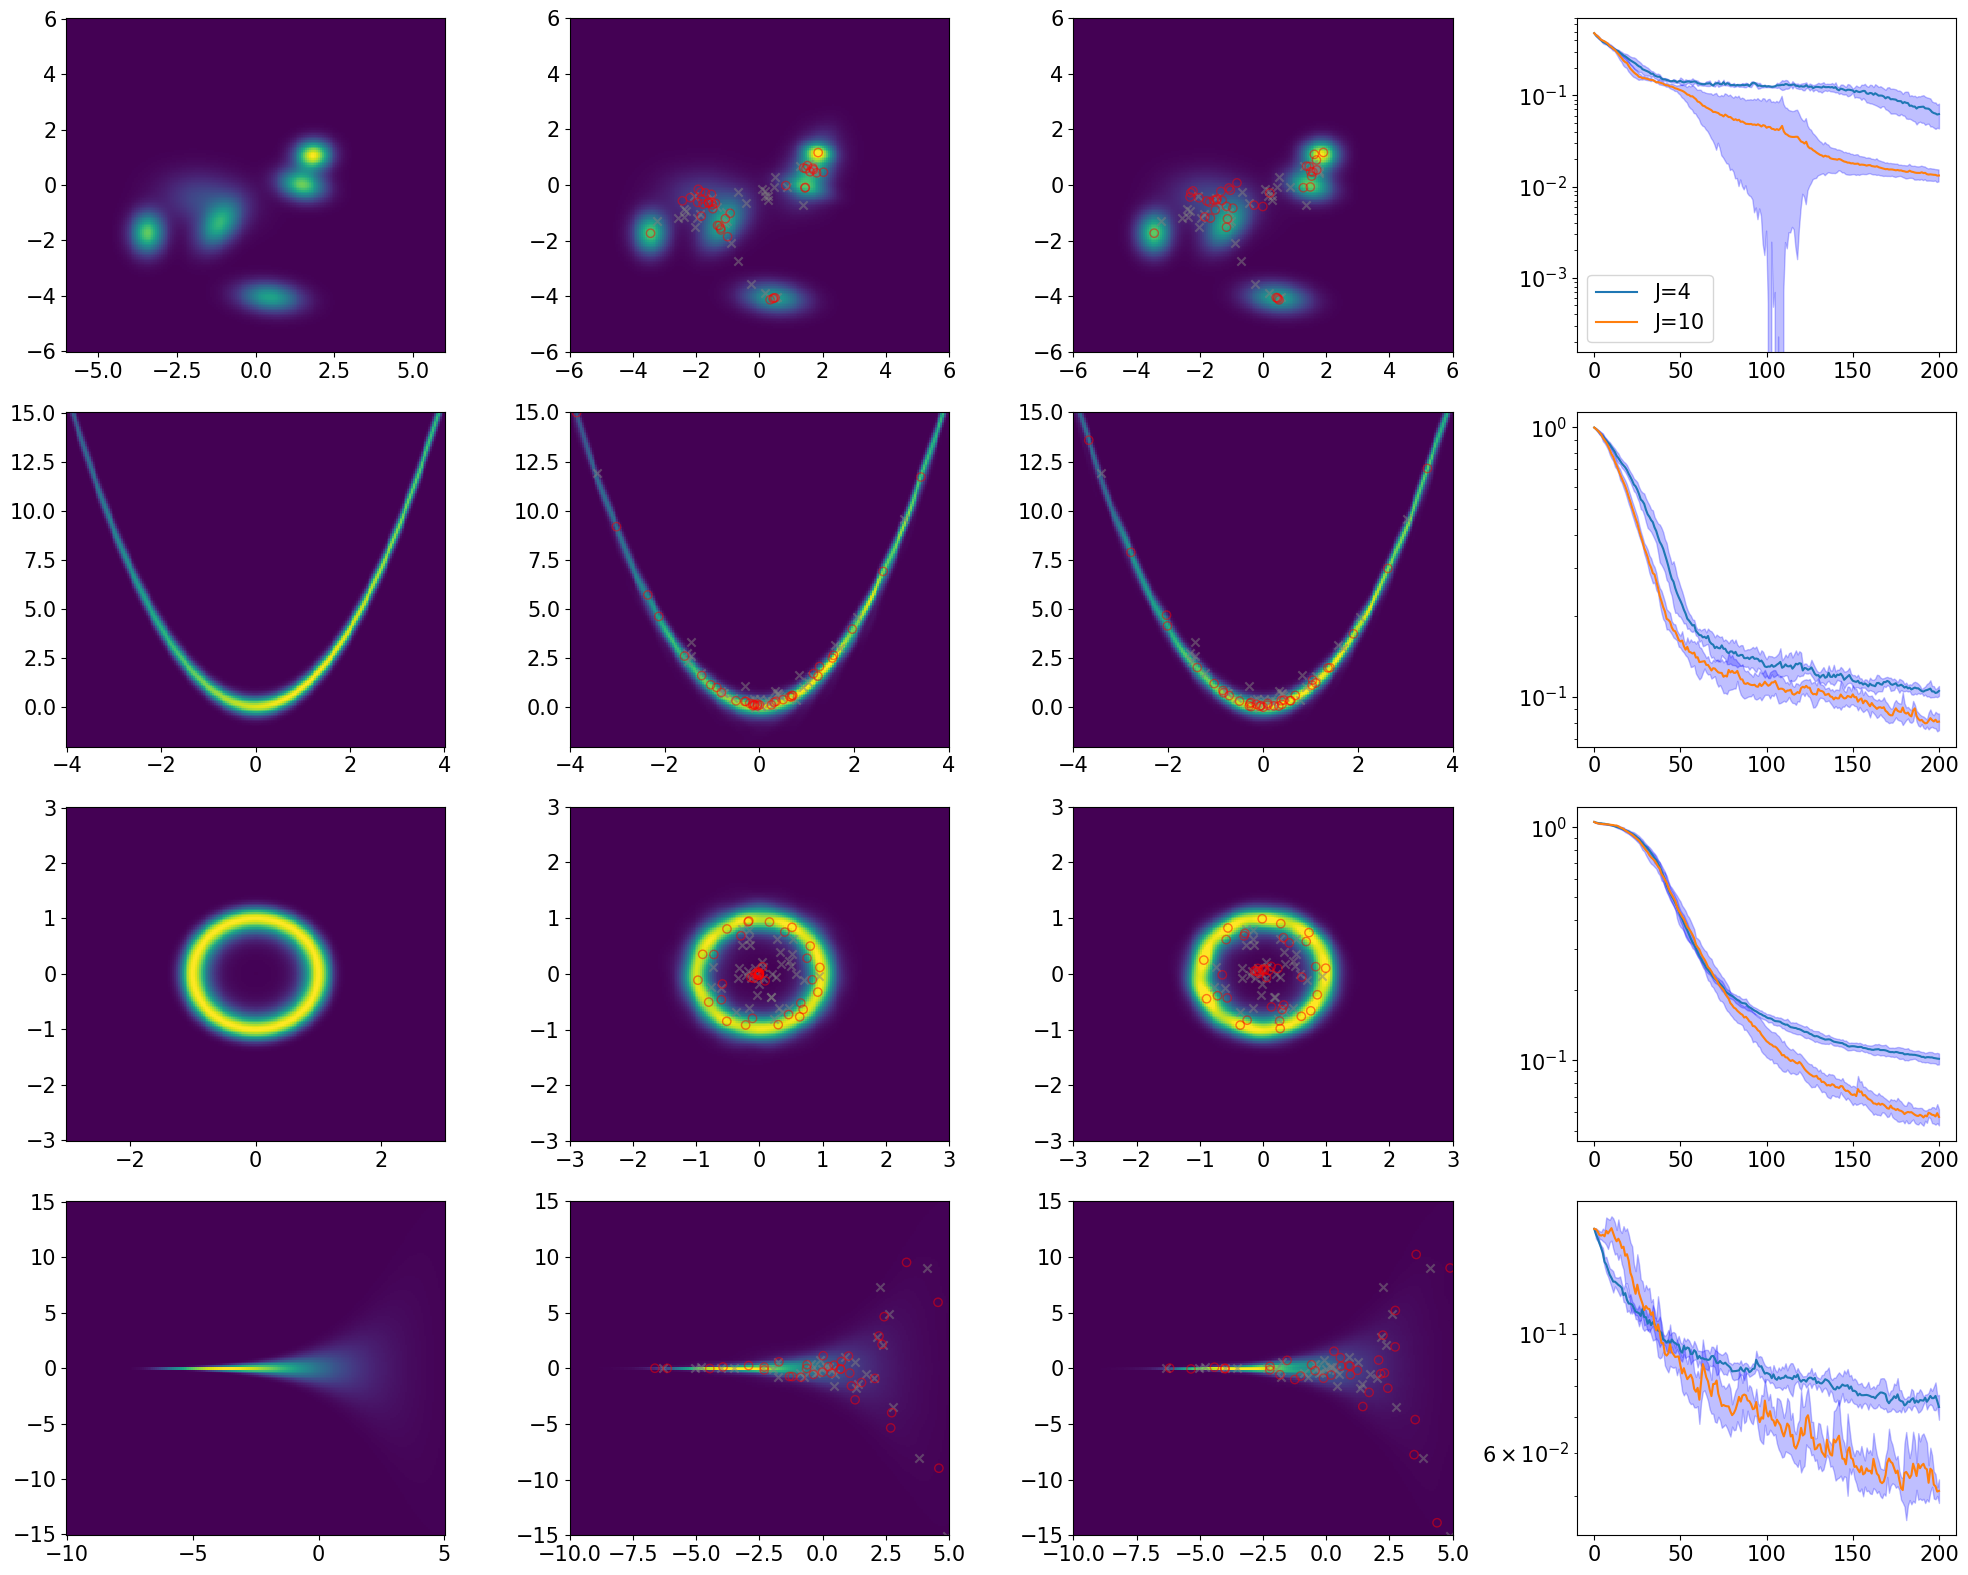

In [3]:
N_modes = 40 # number of modes in Gaussian mixture
N_ens = 5 # number of samples to compute expectation using Monte Carlo in GMBBVI
N_x = 2
N_ens_array = [2*N_x, 5*N_x]

fig, ax = PyPlot.subplots(nrows=4, ncols=4, sharex=false, sharey=false, figsize=(20,16))

x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = zeros(N_x), Matrix(I(N_x))
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end


N_iter = 200
N_trials = 5 
dt = 0.5


@info "Running: Gaussian mixture"
N_modes_GM = 6
# x_w_ref = rand(Uniform(0,1), N_modes_GM) 
x_w_ref = ones(N_modes_GM)
x_w_ref = x_w_ref/sum(x_w_ref)
x_mean_ref = 2.0*rand(Normal(0, 1), (N_modes_GM, N_x))
xx_cov_ref = zeros(N_modes_GM, N_x, N_x)
inv_sqrt_xx_cov_ref = []
inv_sqrt_xx_cov_ref_marginal = []
for i = 1:N_modes_GM
    W = rand(Normal(0, 1), (N_x, N_x))
    xx_cov_ref[i,:,:] = 0.25*(W'*W/N_x + I)/2.0
    push!(inv_sqrt_xx_cov_ref, inv(cholesky(xx_cov_ref[i,:,:]).L))
    push!(inv_sqrt_xx_cov_ref_marginal, inv(cholesky(xx_cov_ref[i,1:2,1:2]).L))
end
func_Phi(x) = -log_Gaussian_mixture(x, (x_w_ref, x_mean_ref, inv_sqrt_xx_cov_ref))
func_Phi_marginal(x) = -log_Gaussian_mixture(x, (x_w_ref, x_mean_ref[:,1:2], inv_sqrt_xx_cov_ref_marginal))

x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)
objs = []
for N_ens in N_ens_array
    obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens)  for _ = 1:N_trials]
    push!(objs, obj)
end  
visualization(ax[1,:], objs, func_Phi_marginal; N_ens_array = N_ens_array, x_lim = [-6.0, 6.0], y_lim = [-6.0, 6.0], N_iter = N_iter)



@info "Running: banana shape density"
Gtype = "Banana"
ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
λ = 10.0
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_marginal_args = (y[1:2], ση[1:2], λ, Gtype)
func_Phi(x) = Phi(x, func_args)
func_Phi_marginal(x) = Phi(x, func_marginal_args)

x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)
objs = []
for N_ens in N_ens_array
    obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens)  for _ = 1:N_trials]
    push!(objs, obj)
end    
visualization(ax[2,:], objs, func_Phi_marginal; x_lim=[-4.0, 4.0], y_lim=[-2.0, 15.0], N_iter = N_iter)



@info "Running: circle density"
Gtype = "Circle"
ση = [0.3; ones(N_x-2)]
A = [1.0 0.0; 0.0 1.0]
y = [1.0; zeros(N_x-2)]
func_args = (y, ση, A, Gtype)
func_marginal_args = (y[1:1], ση[1:1], A , Gtype)
func_Phi(x) = Phi(x, func_args)
func_Phi_marginal(x) = Phi(x, func_marginal_args)

x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)
objs = []
for N_ens in N_ens_array
    obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens)  for _ = 1:N_trials]
    push!(objs, obj)
end  
visualization(ax[3,:], objs, func_Phi_marginal; x_lim = [-3.0, 3.0], y_lim = [-3.0, 3.0], N_iter = N_iter)



@info "Running: Funnel example"
Gtype = "Funnel"
ση = ones(N_x)
A = Diagonal(ones(N_x-1))
y = zeros(N_x)
func_args = (y, ση, A, Gtype)
func_marginal_args = (y[1:2], ση[1:2], A[1,1], Gtype)
func_Phi(x) = Phi(x, func_args)
func_Phi_marginal(x) = Phi(x, func_marginal_args)

x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)
objs = []
for N_ens in N_ens_array
    obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens)  for _ = 1:N_trials]
    push!(objs, obj)
end   
visualization(ax[4,:], objs, func_Phi_marginal; x_lim=[-10.0, 5.0], y_lim=[-15.0, 15.0], N_iter = N_iter)


fig.tight_layout()
fig.savefig("GMBBVI-trials-"*string(N_x)*"D.pdf")


